# iTunes music library analysis

## A scientific way of creating playlists for fitness classes

Why... How...

I believe that the good song for the practice is the one I do not hear, or pay attention to. It gives the mood, the rhythm, the flow. But my brain should not catch it. The song should be around, not whithin.

— February 2016 —

## Summary

Bla-Bla-Bla

## Research in detail

#### Preliminaries

I use pandas and matplotlib...

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# set seaborn plot defaults
import seaborn as sns; sns.set()

# format floating point numbers
pd.set_option('float_format', '{:.2f}'.format)

The hero and the foundation of my analysis is the Echo Nest library. 

In [414]:
from pyechonest import config
config.ECHO_NEST_API_KEY="1RNDIJ5SITBKZFDCT"

### Data preparation

For this research I need two datasets. The first one, obviously, is my iTunes music library. The library serves me as a test dataset. 

For the training dataset I made a list of hand picked songs and labaled each song with one of the three classes: "yoga", "cycling", and "focus". The reason I chose these categories for the training dataset is that I wanted to have two very different groups of songs ("yoga" and "cycling") and one more alike group—focus—that might sound similar to the 'yoga' group but at the same time is very different for me. I'd like to find out what song attributes make that difference.

I will start by processing the test data. iTunes xml file contains information that's stored in the iTunes database of the songs in the library. 

#### Test dataset

In [415]:
# iTunes xml file
xml_file = 'itunes_library.xml'

To parse my iTunes library xml file I use [pyItunes](https://github.com/liamks/pyitunes) module.

In [416]:
def get_itunes_song(song):
    """check the validity of the song, 
    exclude podcasts and songs 
    missing artist's name.
    """
    if (song.genre == 'Podcast' or 
        song.genre == u'iTunes U' or 
        song.kind != 'MPEG audio file' or 
        not song.artist): 
        return None 
    else:
        return song.name, song.artist

def parse_itunes_xml(db, xml_file):
    """parse xml and get song's title
    and artist's name.
    """
    from pyItunes import Library
    l = Library(xml_file)
    
    for id, song in l.songs.items():
        try:
            song_title, artist = get_itunes_song(song)
            if not db.get(song_title):
                db[song_title] = {'artist' : artist}
        except TypeError as e:
            continue

I save the data as a sqlite database (DB) and use the [sqlitedict](https://github.com/piskvorky/sqlitedict) library to access it. 

In [4]:
# DB with songs from iTunes library
from sqlitedict import SqliteDict
idb = SqliteDict('./itunes_tracks', autocommit=True)

# call parse_itunes_xml function and 
# write the data into the DB.

# parse_itunes_xml(idb, xml_file)

The next step is to get song attributes from the Echo Nest API.  

In the analysis I use the following track attributes:

* **Acousticness** represents the likelihood a recording was created by solely acoustic means such as voice and acoustic instruments as opposed to electronically such as with synthesized, amplified, or effected instruments;
* **Danceability** describes how suitable a track is for dancing using a number of musical elements (tempo, rhythm stability, beat strength, and overall regularity);
* **Energy** represents a perceptual measure of intensity and powerful activity released throughout the track;
* **Instrumentalnes** is a measure of how likely a song is to be instrumental;
* **Key** identifies the tonic triad, the chord, major or minor;
* **Loudness** measureas the overall loudness of a track in decibels (dB);
* **Mode** indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived;
* **Speechiness** detects the presence of spoken words in a track;
* **Tempo** is the speed or pace of a given piece (in beats per minute);
* **Time signature** specifies how many beats are in each bar (or measure);
* **Valence** describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

Using the Echo Nest python library [pyechonest](https://github.com/echonest/pyechonest) is super easy and straighforward.  

The library has limitations and doesn't provide data for every artist or song. I handle missing items with a "try-except" block.

In [418]:
def get_song_data(artist_name, song_title):
    """ Get track data from the Echo Nest
    database.
    """
    from pyechonest import song
    try: 
        result = song.search(artist=artist_name, 
                             title=song_title)
        song_result = result[0]
        song_data = song_result.audio_summary
        return song_data
    
    except IndexError as e:
        print 'No data for the song', song_title
        return None
    
def add_song_data_to_db(song_title, song_data, db):
    """ Add song data we get from Echo Nest 
    to the DB.
    """
    song_val = {'time_signature' : song_data['time_signature'],
                'energy' : song_data['energy'],
                'tempo' : song_data['tempo'], 
                'speechiness' : song_data['speechiness'],
                'acousticness' : song_data['acousticness'], 
                'danceability' : song_data['danceability'],
                'instrumentalness' : song_data['instrumentalness'],
                'key' : song_data['key'],
                'loudness' : song_data['loudness'],
                'valence' : song_data['valence'],
                'mode' : song_data['mode']}
    value = db[song_title]
    value.update(song_val)
    db[song_title] = value
            
def check_data_in_db(db):
    """ Look for new songs in the DB and get 
    song attributes from the Echo Nest library.
    """
    from time import sleep

    for song_title, value in db.iteritems():
        # Check if the attributes have been added
        if value.get('tempo') or value.get('No_data'): 
            pass
        else:
            song_data = get_song_data(value['artist'], 
                                      song_title)
            # If the song is in the Echo Nest base, 
            # I add the data to the DB.
            if song_data:
                add_song_data_to_db(song_title, 
                                    song_data, db)
                # Echo Nest limits number of requests to 20 per minute
                sleep(8) 
            # If not, I add 'No_data' key to the song. 
            else:
                song_val = {'No_data' : True}
                value.update(song_val)
                db[song_title] = value
                sleep(8)

In [419]:
# Call check_data_in_db function and 
# write the Echo Nest data into the DB.

# check_data_in_db(idb)

#### Training dataset

I use Pandas read_csv function to read csv file and write it into the sqlite dictionary. 

In [5]:
train_db = SqliteDict('./chosen_tracks', autocommit=True)

In [421]:
# Call check_data_in_db function and 
# write the Echo Nest data into the DB.

# check_data_in_db(train_db)

## Data overview  
  
Now I have two sets with song data. Next I read in data from both databases and take a look at what I'm working with.

In [6]:
def read_db_in_pandas(db):
    """ Read the DB and return 
    cleaned version.
    """
    # transpose data
    df = pd.DataFrame(dict(db)).T
    
    # remove rows with no data for a song
    df_clean = df[df['No_data'] != 1]
    
    # convert columns into numbers
    df_clean = df_clean.convert_objects(convert_numeric=True)

    # convert index into a column
    df_clean.reset_index(level=0, inplace=True)
    df_clean.rename(columns = {'index': 'song_title'}, 
                    inplace=True)
    
    # remove the 'No_data' column
    df_clean.drop('No_data', 1, 
                  inplace=True)
    return df_clean

### Test data

In [7]:
test_df = read_db_in_pandas(idb)

In [15]:
print ("There are {0} items in the dataset."
       .format(len(idb)))
print ("{0} items have no data available " 
       "in the Echo Nest DB."
       .format(len(idb) - len(test_df)))
print ("We are left with {0} songs to use as a test set."
       .format(len(test_df)))
print "\nBelow is a random sample of the dataset."
test_df.sample(n=4)

There are 554 items in the dataset.
223 items have no data available in the Echo Nest DB.
We are left with 331 songs to use as a test set.

Below is a random sample of the dataset.


,song_title,acousticness,artist,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
320,You'll Get Enough,0.52,The Delfonics,0.65,0.68,0.00,11,-7.50,0,0.03,123.24,4,0.79
191,Open The Door,0.78,The Men,0.50,0.38,0.86,0,-9.82,1,0.04,121.85,4,0.13
273,Tide,0.55,Junip,0.34,0.25,0.86,5,-13.80,1,0.03,135.22,4,0.20
187,One Life Stand,0.01,Hot Chip,0.73,0.65,0.02,10,-8.01,0,0.05,129.18,4,0.70


I visualize the data to see if there are any patterns. I can change index (x_index, y_index) in simple_df_plot function to see the relationship between different variables.

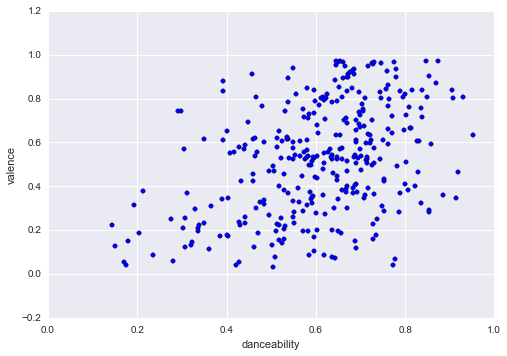

In [9]:
def simple_df_plot(df, x_index, y_index):
    # list columns with numeric values
    cols = df.select_dtypes(exclude=[object]).columns
    plt.scatter(df[cols[x_index]], 
                df[cols[y_index]])
    plt.clim(-0.5, 2.5)
    plt.xlabel(cols[x_index])
    plt.ylabel(cols[y_index]);


# make a plot
simple_df_plot(test_df, 1, 10)

It seems there's a strong correlation between danceability (x_index = 1) of the track and its valence (y_index = 10), which sounds reasonable. 

I've also noticed that there is a negative correlation between acousticness (x_index = 0) and energy (y_index = 2): the higher the enegry of the track is the lower is its acousticness. 

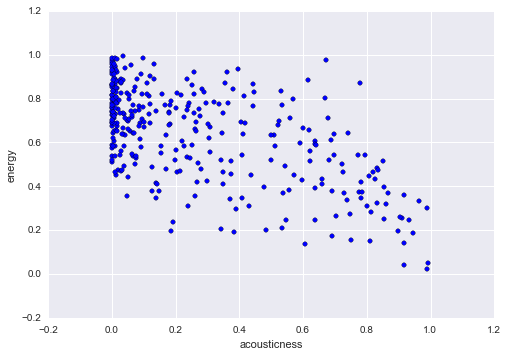

In [10]:
simple_df_plot(test_df, 0, 2)

I'll explore this later... Let's move on to the training data.


### Training data

In [12]:
train_df = read_db_in_pandas(train_db)

In [19]:
print ("There are {0} items in the dataset."
       .format(len(train_db)))
print ("{0} items have no data available "
       "in the Echo Nest DB."
       .format(len(train_db) - len(train_df)))
print ("We are left with {0} songs to use as training data."
       .format(len(train_df)))
print "\nBelow is a random sample of the dataset."
train_df.sample(n=4)

There are 128 items in the dataset.
37 items have no data available in the Echo Nest DB.
We are left with 91 songs to use as training data.

Below is a random sample of the dataset.


,song_title,acousticness,artist,category,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
11,Bittersweet (Part 2 - Gat),0.85,Stevin McNamara,yoga,0.85,0.22,0.92,7,-17.54,1,0.05,114.05,4,0.12
45,Levy,0.73,Node,focus,0.45,0.29,0.84,7,-21.09,1,0.04,139.84,4,0.06
9,Azure Azure,0.23,Tim Hecker,focus,0.07,0.33,0.82,8,-15.92,1,0.05,77.50,3,0.04
64,Sister of pearl,0.08,Baio,cycling,0.73,0.65,0.21,5,-7.73,1,0.04,125.06,4,0.94


In [17]:
# list of categories
categories = list(pd.unique(train_df.category.ravel()))
print ("Tracks in the dataset belong " 
       "to {} categories: {}."
       .format(len(categories), ", ".join(categories)))

# count tracks in each category
cat_count = pd.value_counts(train_df.category.ravel())

# print categories
for category in categories:
    print ("{} tracks represent \'{}\' category."
           .format(cat_count[category], category))

Tracks in the dataset belong to 3 categories: cycling, focus, yoga.
26 tracks represent 'cycling' category.
34 tracks represent 'focus' category.
31 tracks represent 'yoga' category.


Track attributes might speak for themselves for an ace musician but I've no idea how to assess the level of the tempo or valence here. Is it high? Low? How different is it? To make it clearer I'll compare the three groups. 

In [18]:
# Should use groupby function

def group_and_describe(category):
    # describe each category
    group = train_df[train_df['category'] == category]
    group_descr = group.describe(percentiles=None).loc[['mean', 'std']]
    return group_descr

grouped_df = [group_and_describe(category) for category in categories]

result = pd.concat(grouped_df, 
                   keys=categories, 
                   names=['category', 'measures'])
# sort the table to make it more readable
result.sortlevel(level=1).reorder_levels(['measures', 'category'])

acousticness  danceability  energy  instrumentalness  key  \
measures category                                                              
mean     cycling           0.11          0.60    0.79              0.08 5.58   
         focus             0.56          0.33    0.33              0.88 6.09   
         yoga              0.84          0.44    0.19              0.81 5.84   
std      cycling           0.22          0.14    0.14              0.19 4.06   
         focus             0.37          0.23    0.23              0.16 3.71   
         yoga              0.22          0.19    0.14              0.25 2.97   

                   loudness  mode  speechiness  tempo  time_signature  valence  
measures category                                                               
mean     cycling      -5.97  0.77         0.06 136.66            4.00     0.70  
         focus       -19.40  0.56         0.05 113.51            3.76     0.21  
         yoga        -19.55  0.68         0.04 110.50            3.39     0.23  
std      cycling       2.51  0.43         0.03  22.40            0.00     0.21  
         focus         6.69  0.50         0.03  38.17            0.85     0.20  
         yoga          5.85  0.48         0.01  27.25            1.05     0.21

This table gives...  
Next step is to visualize the data.

First I create a new column in the DF where I'll assign a numeric class to each track.

In [20]:
def label_categories(row):
    # make a list of categories
    categories = list(pd.unique(train_df.category.ravel()))
    for item in categories:
        if row['category'] == item:
            return categories.index(item) 
        
train_df['num_cat'] = train_df.apply (lambda row: label_categories(row), axis=1)

Let's plot the data.

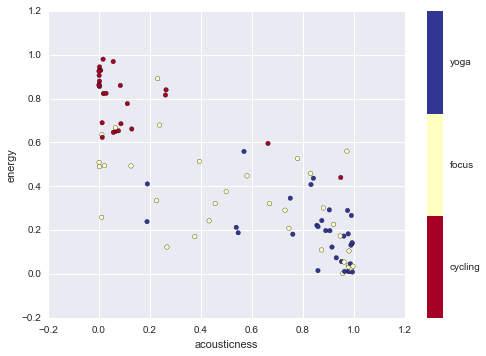

In [21]:
def plot_df_categories(df, x_index, y_index):
    # list columns with numeric values
    cols = df.select_dtypes(exclude=[object]).columns
    
    # list of categories
    cat_li = np.sort(df.category.unique()).tolist()
    # the formatter will label the colorbar with categories
    formatter = plt.FuncFormatter(lambda i, 
                                   *args: cat_li[int(i)])
    plt.scatter(df[cols[x_index]], 
                df[cols[y_index]],
                c=df.num_cat, 
                cmap=plt.cm.get_cmap('RdYlBu', 3))
    plt.colorbar(ticks=[0, 1, 2], 
                 format=formatter)
    plt.clim(-0.5, 2.5)
    plt.xlabel(cols[x_index])
    plt.ylabel(cols[y_index]);
    
#plot the data
plot_df_categories(train_df, 0, 2)

As expected, 'yoga' and 'cycling' form two separate groups. Tracks in the 'cycling' group tend to be more energetic and less acoustic. Tracks in the 'yoga' groupd have high level of acousticness and low level of energy. 

Ironically, the 'focus' class is the least focused. 

### Cleaning data

Before I start working with scikit-learn library, I need to rearrange both datasets a bit.
#### — Training set —

In [27]:
# Training dataset

# target data
target = train_df.num_cat

# keep only numerical values
cols = train_df.select_dtypes(exclude=[object]).columns
train_matrix = train_df[cols]

# remove target column
train_matrix = train_matrix.drop(['num_cat'], axis=1)

# standardize features
train_matrix = train_matrix.apply(lambda x: (x - np.mean(x)) 
                                               / np.std(x))
# review the set
train_matrix.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
0,0.34,-0.25,0.60,-1.57,-1.38,0.71,0.72,-0.79,2.20,0.36,0.73
1,0.63,-1.24,0.37,0.91,1.17,-0.38,-1.39,1.47,-0.10,0.36,-1.05
2,1.12,-1.57,-1.34,0.84,0.04,-1.67,0.72,-0.46,-0.97,0.36,-1.07
3,0.76,-1.03,0.15,0.77,-1.38,-0.46,0.72,-0.49,-0.92,0.36,-0.46
4,1.16,-1.21,-0.92,0.81,0.89,-0.49,-1.39,-0.44,0.48,0.36,-1.07


#### — Test set —

In [31]:
# keep only numerical values
cols = test_df.select_dtypes(exclude=[object]).columns
test_matrix = test_df[cols]

# standardize features
test_matrix = test_matrix.apply(lambda x: (x - np.mean(x)) 
                                / np.std(x))

# review the dataset
test_matrix.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
0,-0.91,-0.03,0.72,-0.37,-0.31,0.24,-1.13,-0.48,-0.78,0.15,0.48
1,0.41,-1.91,-1.60,1.75,1.33,-0.54,-1.13,-0.45,0.95,-3.33,-0.60
2,1.84,1.24,-1.53,1.78,0.51,-1.38,0.89,-0.20,0.52,0.15,0.80
3,-0.80,-2.01,0.13,-0.74,1.06,0.44,0.89,-0.29,0.24,-3.33,0.89
4,1.35,-1.85,-1.06,1.57,-1.40,-2.67,-1.13,-0.18,-0.09,0.15,-1.50


Finally, we convert the processed training data from a Pandas dataframe into a numerical (Numpy) array.

In [33]:
train_data = train_matrix.values
train_data = np.nan_to_num(train_data)
test_data = test_matrix.values
test_data = np.nan_to_num(test_data)

## Novelty detection

I start my analysis with choosing tracks from the test set that match classes in the training set. For this purpose I use one-class SVM unsupervised algorithm. One-class SVM is used for novelty detection, that is, given a set of samples (training set), it will detect the soft boundary of that set so as to classify new points (test set) as belonging to that set or not.

It's important to point out that the algorithm treats the training data as not polluted by outliers.

I use radial basis function, or 'rbf', kernel; 'nu' value has been chosen by trial and error method. 

In [34]:
from sklearn import svm

# fit the model
svm_model = svm.OneClassSVM(kernel="rbf", nu=0.07)
svm_model.fit(train_data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.07, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [35]:
# new observations, or test data, can now be sorted 
# as inliers or outliers with a predict method
y_pred_test = svm_model.predict(test_data)

# number of tracks outside set boudaries
# inliers are labeled 1, while outliers are labeled -1
n_error_test = y_pred_test[y_pred_test == -1].size

In [37]:
print ("Number of tracks that match the training set: {0}."
       "\nNumber of tracks outside set boudaries: {1}."
       .format((y_pred_test.size - n_error_test), 
               n_error_test))

Number of tracks that match the training set: 185.
Number of tracks outside set boudaries: 146.


Next step is to classify tracks that match the training set.  
First, I record the result of novelty detection algorithm to the test dataframe and to the test set. 

In [44]:
# add to the DF
match = pd.DataFrame({'match': y_pred_test})
test_result_df = pd.concat([test_df, match], axis=1)
test_result_df.head()

,song_title,acousticness,artist,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match
0,ADDICTIVE,0.00,Faithless,0.60,0.79,0.14,4,-8.00,0,0.03,98.97,4,0.64,1.00
1,ANOTHER NIGHT IN,0.39,TINDERSTICKS,0.31,0.30,0.85,10,-11.28,0,0.03,142.21,3,0.37,-1.00
2,After All Is Said and Done,0.80,Junip,0.80,0.31,0.86,7,-14.80,1,0.05,131.53,4,0.72,-1.00
3,All My Loving,0.04,The Beatles,0.30,0.67,0.01,9,-7.17,1,0.04,124.46,3,0.74,-1.00
4,Almost Fell,0.66,Nicolas Jaar,0.32,0.41,0.79,0,-20.17,0,0.05,116.17,4,0.14,-1.00


In [47]:
# add novelty results to the set
# convert y_pred_test from a 1d array into a 2d array
print 'Before:', y_pred_test.shape
print 'After the magic: ', y_pred_test[:, None].shape
print 'Test set shape: ', test_data.shape

Before: (331,)
After the magic:  (331, 1)
Test set shape:  (331, 11)


In [64]:
# create new array with results
post_svm_test = np.concatenate((test_data, y_pred_test[:, None]), 1)
post_svm_test.shape

(331, 12)

In [65]:
# add index to the set
set_index = np.asarray(range(331))[:, None]
post_svm_test = np.concatenate((set_index, post_svm_test), 1)

# review the result 
post_svm_test[:3]

array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ],
       [ 1.        ,  0.4141471 , -1.91387049, -1.6011356 ,  1.74694552,
         1.33281141, -0.54391301, -1.12566571, -0.44520947,  0.9529425 ,
        -3.32818717, -0.60456148, -1.        ],
       [ 2.        ,  1.83629482,  1.24130056, -1.53144213,  1.77772202,
         0.51179297, -1.3826734 ,  0.88836321, -0.20106329,  0.52414909,
         0.14698618,  0.80421917, -1.        ]])

In [66]:
# keep only matching items
matching_test = post_svm_test[post_svm_test[:, 12] == 1]

# review the result
matching_test.shape

(185, 13)

## Classification

I'm going to compare the result of three different models:
1. K nearest neighbors classification
2. Random Forest Classification
3. SVC

The algorithm I use is as follows:
1. Tune parameters using GridSearchCV.  
I use GridSearchCV to test the desired range of input parameters, and review the performance of each set of values on a cross-validation basis. 
2. Create and train a model.
3. Make prediction.
4. Keep only tracks with probability higher than 70%.

Next: 
1. classify data in post_svm_test (supervised classification)
2. cross_validate models
3. plot data
4. classify data in unmatched 

### K nearest neighbors

In [68]:
from sklearn import neighbors
from sklearn.grid_search import GridSearchCV

# tune parameters
parameter_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
}
grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), parameter_grid,
                            cv=5, verbose=3)

grid_search.fit(train_data, target)

# review the result
grid_search.grid_scores_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.650000 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.777778 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.611111 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.611111 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.588235 -   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........ n_neighbors=3, weights=distance, score=0.650000 -   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........ n_n

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished



[CV] ........ n_neighbors=7, weights=distance, score=0.705882 -   0.0s


[mean: 0.64835, std: 0.06803, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.65934, std: 0.06151, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.68132, std: 0.03381, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.68132, std: 0.03381, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.70330, std: 0.05816, params: {'n_neighbors': 7, 'weights': 'uniform'},
 mean: 0.69231, std: 0.05923, params: {'n_neighbors': 7, 'weights': 'distance'}]

In [131]:
# sort the results 
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

knn_best_score = grid_search.best_score_
best_params = grid_search.best_params_

# print the winner
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nBest parameters: {1}."
       .format(knn_best_score, 
               best_params
              ))

The best-performing tuning parameters
Best score: 0.769230769231;
Best parameters: {'max_features': 0.5, 'max_depth': 5.0}.


In [77]:
# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], 
                                    weights=best_params['weights'])

# train the model
knn.fit(train_data, target)

# make predictions
# exclude index and novelty result
knn_output = knn.predict(matching_test[:, 1:12])

In [79]:
# print the result
print ("Number of tracks in the test set: {0}." 
       "\nNumber of tracks assigned to the \"cycling\" class: {1}."
       "\nNumber of tracks assigned to the \"focus\" class: {2}."
       "\nNumber of tracks assigned to the \"yoga\" class: {3}." 
       .format(knn_output.size, 
               knn_output[knn_output == 0].size,
               knn_output[knn_output == 1].size,
               knn_output[knn_output == 2].size))

Number of tracks in the test set: 185.
Number of tracks assigned to the "cycling" class: 87.
Number of tracks assigned to the "focus" class: 48.
Number of tracks assigned to the "yoga" class: 50.


In [86]:
# add the result to the matching set
knn_set = np.concatenate((matching_test, knn_output[:, None]), 1)

# review the result
print knn_set.shape
print "\nSample of the resulting set: "
knn_set[:3]

(185, 14)

Sample of the resulting set: 


array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  2.        ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  0.        ]])

In [88]:
# calculate probability
probability = knn.predict_proba(matching_test[:, 1:12])

# make a list of highest probabilities
max_proba = np.asarray([x.max() for x in probability])

# review the result
max_proba.shape

(185,)

In [89]:
# add probability to the set
knn_proba = np.concatenate((knn_set, max_proba[:, None]), 1)

In [90]:
knn_proba[:3]

array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  2.        ,  0.42857143],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ,  0.42857143],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  0.        ,  1.        ]])

Now I transform the set back to pandas dataframe.

In [93]:
# list of column names
li = ['index'] + train_matrix.columns.tolist() + ['match', 'num_cat', 'probability']
li

['index',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence',
 'match',
 'num_cat',
 'probability']

In [104]:
# transform into a DF for easier manipulations
knn_df = pd.DataFrame(knn_proba, columns=li)

# change column type to integer
knn_df[['index', 'match', 'num_cat']] = knn_df[['index', 'match', 'num_cat']].astype(int)

# change index to the original index
knn_df = knn_df.set_index(['index'])

# review the result
knn_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,num_cat,probability
index,,,,,,,,,,,,,,
83,-0.59,-0.38,0.58,-0.16,0.51,-0.01,0.89,-0.35,0.34,0.15,-1.04,1,2,0.57
130,-0.72,0.76,0.50,-0.50,1.61,1.00,-1.13,-0.47,0.46,0.15,1.76,1,0,0.86
283,-0.34,-0.46,-0.76,-0.76,-0.04,-0.01,0.89,-0.07,-1.47,0.15,-0.60,1,2,0.71


In [109]:
# add a 0.7 threshold for probability
knn_high_proba = knn_df[knn_df['probability'] >= 0.7]

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,num_cat,probability
index,,,,,,,,,,,,,,
6,-0.87,-0.49,0.97,-0.59,0.51,-0.07,0.89,-0.36,0.26,0.15,0.89,1,0,1.00
13,0.50,-0.62,0.80,-0.77,-0.86,0.43,-1.13,0.62,1.67,0.15,0.23,1,0,0.71
16,-0.91,0.96,0.77,-0.77,-0.04,0.24,-1.13,-0.25,-0.34,0.15,1.28,1,0,0.86
22,0.38,0.22,0.96,-0.77,0.51,0.66,0.89,-0.33,-1.10,0.15,1.46,1,0,0.86
29,1.27,0.31,-1.15,-0.77,0.51,-1.15,-1.13,-0.42,-0.30,0.15,-1.34,1,2,0.71


In [113]:
# print the result
print ("Number of tracks with class probability higher than 70%: {0}." 
       "\nNumber of tracks assigned to the \"cycling\" class: {1}."
       "\nNumber of tracks assigned to the \"focus\" class: {2}."
       "\nNumber of tracks assigned to the \"yoga\" class: {3}." 
       .format(len(knn_high_proba), 
               len(knn_high_proba[knn_high_proba['num_cat'] == 0]),
               len(knn_high_proba[knn_high_proba['num_cat'] == 1]),
               len(knn_high_proba[knn_high_proba['num_cat'] == 2])))

Number of tracks with class probability higher than 70%: 108.
Number of tracks assigned to the "cycling" class: 60.
Number of tracks assigned to the "focus" class: 15.
Number of tracks assigned to the "yoga" class: 33.


### Random Forest Classifier

The next model I use is Random Forest Classifier. 
I start with GridSearchCV parameter tuning to choose the optimal number of features considered at each step a branch is made (max_features: 50%, 70% or 100% of features) and the maximum number of branches (max_depth: 5 levels, 8 levels or no limitations).

In [116]:
from sklearn.ensemble import RandomForestClassifier

# tune parameters
parameter_grid = {
    'max_features': [0.5, 0.7, 1.],
    'max_depth': [5., 8., None]
}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators = 100), 
                           parameter_grid, 
                           cv=5, verbose=3)

grid_search.fit(train_data, target)

# review the results
grid_search.grid_scores_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.700000 -   0.2s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.833333 -   0.2s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.722222 -   0.1s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.722222 -   0.2s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.882353 -   0.1s
[CV] max_features=0.7, max_depth=5.0 .................................
[CV] ........ max_features=0.7, max_depth=5.0, score=0.700000 -   0.1s
[CV] max_features=0.7, max_depth=5.0 .................................
[CV] ........ max

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    4.5s



[CV] max_features=0.5, max_depth=None ................................
[CV] ....... max_features=0.5, max_depth=None, score=0.666667 -   0.2s
[CV] max_features=0.5, max_depth=None ................................
[CV] ....... max_features=0.5, max_depth=None, score=0.611111 -   0.2s
[CV] max_features=0.5, max_depth=None ................................
[CV] ....... max_features=0.5, max_depth=None, score=0.823529 -   0.3s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.700000 -   0.2s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.722222 -   0.1s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.722222 -   0.2s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.722222 -   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.9s finished


[mean: 0.76923, std: 0.07222, params: {'max_features': 0.5, 'max_depth': 5.0},
 mean: 0.74725, std: 0.06718, params: {'max_features': 0.7, 'max_depth': 5.0},
 mean: 0.75824, std: 0.08437, params: {'max_features': 1.0, 'max_depth': 5.0},
 mean: 0.73626, std: 0.05600, params: {'max_features': 0.5, 'max_depth': 8.0},
 mean: 0.73626, std: 0.05854, params: {'max_features': 0.7, 'max_depth': 8.0},
 mean: 0.73626, std: 0.06827, params: {'max_features': 1.0, 'max_depth': 8.0},
 mean: 0.71429, std: 0.07625, params: {'max_features': 0.5, 'max_depth': None},
 mean: 0.73626, std: 0.04360, params: {'max_features': 0.7, 'max_depth': None},
 mean: 0.73626, std: 0.04360, params: {'max_features': 1.0, 'max_depth': None}]

In [130]:
# sort the results 
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

# print the winner
rfc_best_score = grid_search.best_score_
best_params = grid_search.best_params_
max_features = best_params['max_features']
max_depth = best_params['max_depth']
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nMax features: {1}%;"
       "\nMax depth: {2} levels."
       .format(rfc_best_score, 
               int(max_features*100),
              int(max_depth)))


The best-performing tuning parameters
Best score: 0.769230769231;
Max features: 50%;
Max depth: 5 levels.


In [118]:
# set tuning parameters to the model
rfc = RandomForestClassifier(n_estimators=100, 
                             max_features=max_features, 
                             max_depth=max_depth)

# train the model
rfc_model = rfc.fit(train_data, target)

# make predictions
rfc_output = rfc_model.predict(matching_test[:, 1:12])

In [119]:
# print the result
print ("Number of tracks in the test set: {0}." 
       "\nNumber of tracks assigned to the \"cycling\" class: {1}."
       "\nNumber of tracks assigned to the \"focus\" class: {2}."
       "\nNumber of tracks assigned to the \"yoga\" class: {3}." 
       .format(rfc_output.size, 
               rfc_output[rfc_output == 0].size,
               rfc_output[rfc_output == 1].size,
               rfc_output[rfc_output == 2].size))

Number of tracks in the test set: 185.
Number of tracks assigned to the "cycling" class: 74.
Number of tracks assigned to the "focus" class: 76.
Number of tracks assigned to the "yoga" class: 35.


The highest number of tracks are assigned to the "focus" class. To confirm I plot the data. 

In [ ]:
# make a plot

In [120]:
# add the result to the matching set
rfc_set = np.concatenate((matching_test, rfc_output[:, None]), 1)

# review the result
print rfc_set.shape
print "\nSample of the resulting set: "
rfc_set[:3]

(185, 14)

Sample of the resulting set: 


array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  1.        ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  1.        ]])

In [121]:
# calculate probability
probability = rfc.predict_proba(matching_test[:, 1:12])

# make a list of highest probabilities
max_proba = np.asarray([x.max() for x in probability])

# review the result
max_proba.shape

(185,)

In [124]:
# add probability to the set
rfc_proba = np.concatenate((rfc_set, max_proba[:, None]), 1)

In [126]:
rfc_proba[:3]

array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  1.        ,  0.528234  ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ,  0.87901213],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  1.        ,  0.4221937 ]])

Now I transform the set back to pandas dataframe.

In [127]:
# transform into a DF for easier manipulations
rfc_df = pd.DataFrame(rfc_proba, columns=li)

# change column type to integer
rfc_df[['index', 'match', 'num_cat']] = rfc_df[['index', 'match', 'num_cat']].astype(int)

# change index to the original index
rfc_df = rfc_df.set_index(['index'])

# review the result
rfc_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,num_cat,probability
index,,,,,,,,,,,,,,
265,-0.91,0.70,0.92,-0.75,1.06,1.14,-1.13,-0.44,0.74,0.15,1.71,1,0,0.94
328,1.21,0.53,0.08,0.31,0.51,-0.35,0.89,0.14,-0.74,0.15,0.32,1,2,0.63
266,-0.57,0.59,0.26,1.09,0.51,0.41,-1.13,-0.50,-0.74,0.15,0.06,1,1,0.67


In [128]:
# add a 0.7 threshold for probability
rfc_high_proba = rfc_df[rfc_df['probability'] >= 0.7]

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,num_cat,probability
index,,,,,,,,,,,,,,
5,0.01,-0.97,0.53,1.62,-1.40,-0.84,0.89,-0.48,-0.92,0.15,0.38,1,1,0.88
22,0.38,0.22,0.96,-0.77,0.51,0.66,0.89,-0.33,-1.10,0.15,1.46,1,0,0.80
38,-0.89,0.33,1.43,-0.77,0.79,1.25,0.89,2.90,0.06,0.15,0.21,1,0,0.90
42,-0.90,0.73,1.08,-0.76,-1.13,0.66,0.89,-0.29,0.46,0.15,0.36,1,0,0.82
46,-0.04,0.08,0.85,-0.77,-1.40,1.24,0.89,-0.51,-0.30,0.15,0.74,1,0,0.89


In [129]:
# print the result
print ("Number of tracks with class probability higher than 70%: {0}." 
       "\nNumber of tracks assigned to the \"cycling\" class: {1}."
       "\nNumber of tracks assigned to the \"focus\" class: {2}."
       "\nNumber of tracks assigned to the \"yoga\" class: {3}." 
       .format(len(rfc_high_proba), 
               len(rfc_high_proba[rfc_high_proba['num_cat'] == 0]),
               len(rfc_high_proba[rfc_high_proba['num_cat'] == 1]),
               len(rfc_high_proba[rfc_high_proba['num_cat'] == 2])))

Number of tracks with class probability higher than 70%: 47.
Number of tracks assigned to the "cycling" class: 30.
Number of tracks assigned to the "focus" class: 13.
Number of tracks assigned to the "yoga" class: 4.


### Support Vector Machine Classifier

In [132]:
from sklearn.svm import SVC

# tune parameters
parameter_grid = {
    'C': [1., 5., 10.],
    'gamma': [0.1, 1.],
}

grid_search = GridSearchCV(SVC(kernel='rbf'), 
                           parameter_grid, 
                           cv=5, verbose=3)

grid_search.fit(train_data, target)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=1.0, gamma=0.1 ................................................
[CV] ....................... C=1.0, gamma=0.1, score=0.700000 -   0.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ....................... C=1.0, gamma=0.1, score=0.888889 -   0.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ....................... C=1.0, gamma=0.1, score=0.722222 -   0.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ....................... C=1.0, gamma=0.1, score=0.888889 -   0.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ....................... C=1.0, gamma=0.1, score=0.764706 -   0.0s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ....................... C=1.0, gamma=1.0, score=0.600000 -   0.0s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished



[CV] C=10.0, gamma=0.1 ...............................................
[CV] ...................... C=10.0, gamma=0.1, score=0.777778 -   0.0s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ...................... C=10.0, gamma=0.1, score=0.666667 -   0.0s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ...................... C=10.0, gamma=0.1, score=0.588235 -   0.0s
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ...................... C=10.0, gamma=1.0, score=0.550000 -   0.0s
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ...................... C=10.0, gamma=1.0, score=0.444444 -   0.0s
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ...................... C=10.0, gamma=1.0, score=0.555556 -   0.0s
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ...................... C=10.0, gamma=1.0, score=0.500000 -   0.0s
[CV] 

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [1.0, 5.0, 10.0], 'gamma': [0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [133]:
# sort the results 
sorted(grid_search.grid_scores_, key=lambda x: x.mean_validation_score)

# choose best parameters
svc_best_score = grid_search.best_score_
best_params = grid_search.best_params_
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nBest parameters: {1}."
       .format(svc_best_score, 
               best_params
              ))

The best-performing tuning parameters
Best score: 0.791208791209;
Best parameters: {'C': 1.0, 'gamma': 0.1}.


Training SVMs with probability=True can be quite a lot more expensive than a vanilla, non-probabilistic SVM. But since it's a small set it doesn't make much difference. 

In [144]:
# create the model
svc_model = SVC(kernel='rbf', 
                C=best_params['C'], 
               gamma=best_params['gamma'],
               probability=True)

# train the model
svc_model.fit(train_data, target)

# make predictions
# exclude index and novelty result
svc_output = svc_model.predict(matching_test[:, 1:12])

In [140]:
print ("Number of tracks in the test set: {0}." 
       "\nNumber of tracks assigned to the \"cycling\" class: {1}."
       "\nNumber of tracks assigned to the \"focus\" class: {2}."
       "\nNumber of tracks assigned to the \"yoga\" class: {3}." 
       .format(svc_output.size, 
               svc_output[svc_output == 0].size,
               svc_output[svc_output == 1].size,
               svc_output[svc_output == 2].size))

Number of tracks in the test set: 185.
Number of tracks assigned to the "cycling" class: 64.
Number of tracks assigned to the "focus" class: 72.
Number of tracks assigned to the "yoga" class: 49.


In [141]:
# add the result to the matching set
svc_set = np.concatenate((matching_test, svc_output[:, None]), 1)

# review the result
print svc_set.shape
print "\nSample of the resulting set: "
svc_set[:3]

(185, 14)

Sample of the resulting set: 


array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  1.        ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  0.        ]])

In [143]:
# calculate probability
probability = svc_model.predict_proba(matching_test[:, 1:12])

# make a list of highest probabilities
max_proba = np.asarray([x.max() for x in probability])

# review the result
max_proba.shape

(185,)

In [146]:
# add probability to the set
svc_proba = np.concatenate((svc_set, max_proba[:, None]), 1)

Now I transform the set back into pandas dataframe.

In [147]:
# transform into a DF for easier manipulations
svc_df = pd.DataFrame(svc_proba, columns=li)

# change column type to integer
svc_df[['index', 'match', 'num_cat']] = svc_df[['index', 'match', 'num_cat']].astype(int)

# change index to the original index
svc_df = svc_df.set_index(['index'])

# review the result
svc_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,num_cat,probability
index,,,,,,,,,,,,,,
243,-0.92,-0.96,-0.30,0.12,1.33,-0.31,-1.13,-0.45,1.21,0.15,-0.39,1,1,0.75
75,-0.93,-0.17,1.49,0.06,-1.40,0.70,0.89,-0.15,0.57,0.15,0.07,1,1,0.45
185,-0.17,-0.95,-0.15,1.40,-0.31,-0.14,0.89,-0.48,-0.02,0.15,-1.58,1,1,0.74


In [148]:
# add a 0.7 threshold for probability
svc_high_proba = svc_df[svc_df['probability'] >= 0.7]

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match,num_cat,probability
index,,,,,,,,,,,,,,
5,0.01,-0.97,0.53,1.62,-1.40,-0.84,0.89,-0.48,-0.92,0.15,0.38,1,1,0.72
16,-0.91,0.96,0.77,-0.77,-0.04,0.24,-1.13,-0.25,-0.34,0.15,1.28,1,0,0.72
29,1.27,0.31,-1.15,-0.77,0.51,-1.15,-1.13,-0.42,-0.30,0.15,-1.34,1,2,0.72
38,-0.89,0.33,1.43,-0.77,0.79,1.25,0.89,2.90,0.06,0.15,0.21,1,0,0.84
40,-0.70,0.39,0.62,1.13,1.61,0.65,-1.13,-0.35,-0.34,0.15,0.66,1,1,0.71


In [149]:
# print the result
print ("Number of tracks with class probability higher than 70%: {0}." 
       "\nNumber of tracks assigned to the \"cycling\" class: {1}."
       "\nNumber of tracks assigned to the \"focus\" class: {2}."
       "\nNumber of tracks assigned to the \"yoga\" class: {3}." 
       .format(len(svc_high_proba), 
               len(svc_high_proba[svc_high_proba['num_cat'] == 0]),
               len(svc_high_proba[svc_high_proba['num_cat'] == 1]),
               len(svc_high_proba[svc_high_proba['num_cat'] == 2])))

Number of tracks with class probability higher than 70%: 54.
Number of tracks assigned to the "cycling" class: 36.
Number of tracks assigned to the "focus" class: 11.
Number of tracks assigned to the "yoga" class: 7.


## START HERE!!!
To do: 
1) which plots can I add?
2) make a copy of the notebook and try the same calculations with 2 classes, yoga and cycling. 
3) try novelty detection class by class

In [61]:
# to plot the graph we need to perform dimensionality reduction
# use PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_reduced = pca.fit_transform(train_data)
print "Original dataset shape:", train_data.shape
print "Reduced dataset shape:", train_reduced.shape

Original dataset shape: (91, 11)
Reduced dataset shape: (91, 2)


Meaning of the 2 components:
-0.392 x acousticness + 0.311 x danceability + 0.421 x energy + -0.392 x instrumentalness + -0.021 x key + 0.425 x loudness + 0.076 x mode + 0.152 x speechiness + 0.214 x tempo + 0.142 x time_signature + 0.377 x valence
0.218 x acousticness + 0.180 x danceability + -0.097 x energy + -0.044 x instrumentalness + -0.674 x key + -0.056 x loudness + 0.398 x mode + -0.476 x speechiness + 0.182 x tempo + -0.016 x time_signature + 0.182 x valence


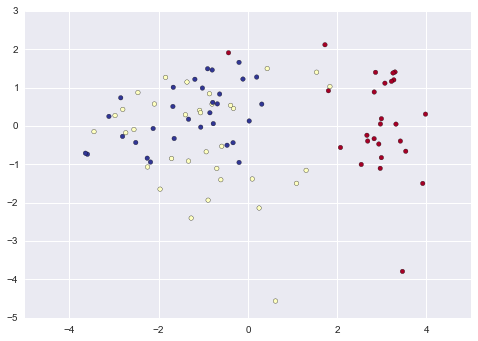

In [62]:
import pylab as pl
pl.scatter(train_reduced[:, 0], train_reduced[:, 1], c=target,
           cmap='RdYlBu')

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            train_matrix.columns)))

This gives us an idea of the relationship between the classes. Essentially, we have found the optimal stretch and rotation in 11-dimensional space that allows us to see the layout of classes, without reference to the labels.

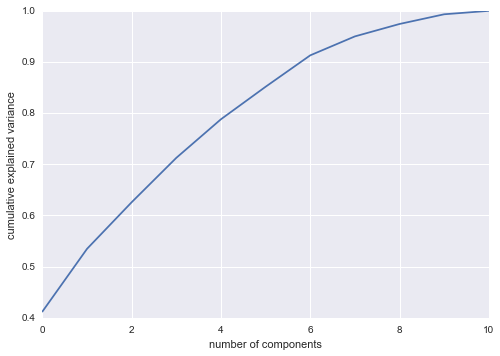

In [33]:
sns.set()
pca = PCA().fit(train_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that our two-dimensional projection loses almost 40% of information (as measured by the explained variance) and that we'd need 6 components to retain 90% of the variance.

In [35]:
pca = PCA(n_components=2)
test_reduced = pca.fit_transform(test_data)
test_reduced.shape

(331, 2)

In [36]:
y = test_reduced

In [73]:
# Use for 1d model
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

In [37]:
# fit the model
clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.1)
clf.fit(X)
y_pred_train = clf.predict(X)
y_pred_test = clf.predict(y)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

In [38]:
n_error_train

18

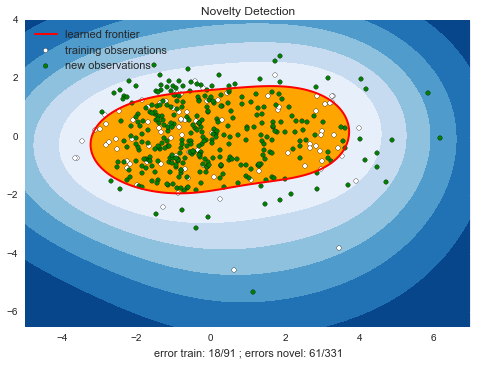

In [39]:
import matplotlib
h = 0.02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 3
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X[:, 0], X[:, 1], c='white')
b2 = plt.scatter(y[:, 0], y[:, 1], c='green')
plt.axis('tight')
plt.xlim((-5, 7))
plt.ylim((-6.5, 4))
plt.legend([a.collections[0], b1, b2],
           ["learned frontier", "training observations",
            "new observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/91 ; errors novel: %d/331"
    % (n_error_train, n_error_test))
plt.show()


In [40]:

# plot the line, the points, and the nearest vectors to the plane
#
#Z = Z.reshape(xx.shape)